# 라이브러리

In [14]:
import os
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split

# Step 1. 데이터 수집하기

---

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

- [songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)


In [86]:
data = pd.read_csv('./data/ChatbotData .csv')

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [87]:
data.head(3)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0


In [135]:
X_train, X_test, y_train, y_test = train_test_split(data['Q'], data['A'], test_size=0.1, random_state=42)

In [136]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10640,), (10640,), (1183,), (1183,))


# Step 2. 데이터 전처리하기

---

영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.



In [19]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    sentence = sentence.strip()
    return sentence

In [137]:
rnd_idx = np.random.randint(0, X_train.shape[0])
print('{}: {}'.format(rnd_idx, preprocess_sentence(X_train[rnd_idx])))
print('{}: {}'.format(rnd_idx, preprocess_sentence(y_train[rnd_idx])))

3727: 이상한 소문이 돌아
3727: 소문은 소문일 뿐이에요 .


# Step 3. SubwordTextEncoder 사용하기

---

한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 `SubwordTextEncoder`를 그대로 사용해보세요.



## 토큰화

In [138]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(X_train + y_train, target_vocab_size=2**13)

In [139]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [140]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [7716]
END_TOKEN의 번호 : [7717]


In [141]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

7718


## 정수 인코딩 & 패딩

In [142]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('{}. 질문: {}'.format(rnd_idx, tokenizer.encode(X_train[rnd_idx])))
print('{}. 답변: {}'.format(rnd_idx, tokenizer.encode(y_train[rnd_idx])))

3727. 질문: [1659, 6482, 7492, 1166]
3727. 답변: [3922, 24, 3922, 83, 540, 7506]


In [143]:
X_len = X_train.apply(lambda x: len(x))

(array([1.850e+02, 9.980e+02, 2.312e+03, 1.720e+03, 2.046e+03, 1.338e+03,
        8.400e+02, 3.670e+02, 3.850e+02, 2.040e+02, 1.310e+02, 4.700e+01,
        3.000e+01, 1.900e+01, 7.000e+00, 3.000e+00, 5.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 1.  ,  3.75,  6.5 ,  9.25, 12.  , 14.75, 17.5 , 20.25, 23.  ,
        25.75, 28.5 , 31.25, 34.  , 36.75, 39.5 , 42.25, 45.  , 47.75,
        50.5 , 53.25, 56.  ]),
 <BarContainer object of 20 artists>)

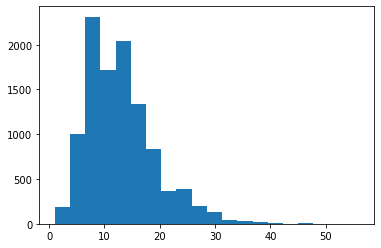

In [144]:
plt.hist(X_len[:-1], bins=20)

In [197]:
X_len[X_len >= 40]

10052    40
11556    45
11248    46
8903     46
11451    42
11348    42
10605    41
11011    48
11462    41
11769    43
9519     41
11053    46
9506     41
11044    47
9273     43
8527     44
11810    56
Name: Q, dtype: int64

In [146]:
under_val = len(X_len[X_len < 40])
print(under_val / df_train_q.shape[0])

0.9983084296588667


In [149]:
MAX_LENGTH = 40

In [150]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [151]:
questions, answers = tokenize_and_filter(X_train, y_train)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 7718
필터링 후의 샘플 개수: 10640
필터링 후의 샘플 개수: 10640


# Step 4. 모델 구성하기

---

위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.



## Positional Encoding

In [152]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

## Scaled Dot Product Attention

In [153]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    
    return output

## Multi Head Attention

In [154]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))

        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷-프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

## Padding

In [155]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [156]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

## Encoder

In [157]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
          d_model, num_heads, name="attention")({
              'query': inputs,
              'key': inputs,
              'value': inputs,
              'mask': padding_mask
          })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(inputs + attention)

    # 두번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
          inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [158]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## Decoder

In [159]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
          shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
          d_model, num_heads, name="attention_1")(inputs={
              'query': inputs,
              'key': inputs,
              'value': inputs,
              'mask': look_ahead_mask
          })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention1 + inputs)

    # 두번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
          d_model, num_heads, name="attention_2")(inputs={
              'query': attention1,
              'key': enc_outputs,
              'value': enc_outputs,
              'mask': padding_mask
          })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention2 + attention1)

    # 세번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
          inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
          outputs=outputs,
          name=name)

In [160]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

## Teacher Forcing 

In [161]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Transformer

In [162]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크하기위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

    # 두번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [163]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3030016     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## Loss, Accuracy

In [164]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [165]:
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


## Learning Rate

In [166]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [167]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## Model Compile & Train

In [168]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [169]:
EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
167/167 [==============================] - 16s 54ms/step - loss: 1.4679 - accuracy: 0.0212
Epoch 2/50
167/167 [==============================] - 9s 54ms/step - loss: 1.2260 - accuracy: 0.0468
Epoch 3/50
167/167 [==============================] - 9s 54ms/step - loss: 1.0437 - accuracy: 0.0503
Epoch 4/50
167/167 [==============================] - 9s 54ms/step - loss: 0.9598 - accuracy: 0.0536
Epoch 5/50
167/167 [==============================] - 9s 53ms/step - loss: 0.9029 - accuracy: 0.0566
Epoch 6/50
167/167 [==============================] - 9s 53ms/step - loss: 0.8481 - accuracy: 0.0599
Epoch 7/50
167/167 [==============================] - 9s 53ms/step - loss: 0.7875 - accuracy: 0.0648
Epoch 8/50
167/167 [==============================] - 9s 54ms/step - loss: 0.7214 - accuracy: 0.0716
Epoch 9/50
167/167 [==============================] - 9s 53ms/step - loss: 0.6502 - accuracy: 0.0796
Epoch 10/50
167/167 [==============================] - 9s 53ms/step - loss: 0.5737 - accur

## Visualisation - Accuracy

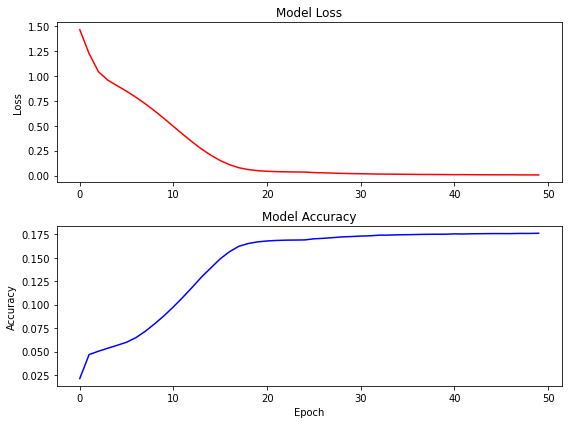

In [195]:
# Create a subplot with 2 rows and 1 column
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Plot loss values on the first subplot
ax[0].plot(history.history['loss'], 'r')
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')

# Plot accuracy values on the second subplot
ax[1].plot(history.history['accuracy'], 'b')
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

> 에포크 200회 결과 50회 정도에서 더 나아지지 않음.  

# Step 5. 모델 평가하기

---

Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.


In [171]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [172]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    return predicted_sentence

In [192]:
def get_chat(number=10):
    for i in range(10):
        rnd_i = np.random.randint(0, X_test.shape[0])
        print('Q: {}'.format(X_test.iloc[rnd_i]))
        print('PRED.A: {}'.format(sentence_generation(X_test.iloc[rnd_i])))
        print('REAL.A: {}'.format(y_test.iloc[rnd_i]))
        print()

## epoch - 10

In [55]:
get_chat(10)

Q: 운동 좀 잘 하고 싶다. 진짜
A: 뭐든 시작해보면 좋을 거예요.

Q: 먼저 인사할까 했는데 짝녀가 먼저 인사해줬어.
A: 다정한게 좋을 거예요.

Q: 오늘도 공기가 뿌얘
A: 운동하고 오세요.

Q: 사랑해 보고싶어
A: 할 수 있을 거예요.

Q: 유부녀 좋아하면 안되지?
A: 저도 모르겠어요.

Q: 인터넷 쇼핑몰에서 바지 샀는데 망함
A: 이해하기 힘드니까요.

Q: 내가 좋아하는 사람이 나 좋아해줬으면 좋겠다
A: 먼저 다가가 보세요.

Q: 친구인데 고백해도 될까?
A: 고민 하고 있으면 썸의 가능성이 높겠네요.

Q: 썸은 좋았는데 연애는 별로
A: 그 누구도 아닌 자기 걸음을 걸으세요.

Q: 남자친구가 진짜 잘 챙겨줘
A: 그래도 상관없어요. 칭찬해주고 싶네요.



## epoch - 200

In [58]:
get_chat(10)

Q: 약 챙겨 먹어야지
A: 제길.

Q: 이별극복후 새로운 설렘
A: 새로운 시작 응원해요.

Q: 헤어지지 말자더니 놔버린 나쁜놈
A: 마음 단단히 잡길 바랄게요.

Q: 등산할까
A: 그러게 말이에요.

Q: 술 먹으면 연락이 안돼
A: 혼자 힘들어하지 마세요.

Q: 헤어진지 5개월차 꿀인생삽니다
A: 항상 좋아했나봐요.

Q: 이별후 그리움이 생생한 오늘
A: 상대의 의견도 물어보세요.

Q: 노는 거 좋아하는 사람은 좋아하면 힘들거야.
A: 지금은 괜찮지만 힘들 거예요.

Q: 오래 연애하고 싶어.
A: 좋은 소식이네요.

Q: 7년사귄 남자친구에게 배신당했어.
A: 저는 저에게 투자하는 시간을 가져요. 예를들면 운동이나 여행같이 잡념을 없앨 수 있는 일들이요.



## epoch - 50

In [193]:
get_chat(10)

Q: 의욕이 없어
PRED.A: 가벼운 산책을 해보세요.
REAL.A: 가벼운 산책을 해보세요.

Q: 독학하려니까 힘들어
PRED.A: 신경 말을 한 사람이 가장 이상할 거예요.
REAL.A: 더 깊은 공부할 수 있을 거예요.

Q: 오늘 상 받았다
PRED.A: 축하드려요.
REAL.A: 축하드려요.

Q: 오랜만에 쇼핑
PRED.A: 제 선물 사오세요.
REAL.A: 득템했길 바라요.

Q: 마지막이겠죠
PRED.A: 고민은 누구나 해요.
REAL.A: 마지막이 아닐 지도 몰라요.

Q: 뷔페 가고 싶어
PRED.A: 저도 딸기 좋아해요. 같이 가요.
REAL.A: 저도 딸기 좋아해요. 같이 가요.

Q: 아쉬움만 남아
PRED.A: 이별 뒤엔 아쉬움이 따를뿐이죠.
REAL.A: 더 많이 배웠길 바라요.

Q: 사랑받고싶어
PRED.A: 잠시 쉬어도 괜찮아요.
REAL.A: 먼저 사랑한다고 말해보세요.

Q: 여름 빨리 지나갔으면
PRED.A: 공부한 만큼 나올 거예요.
REAL.A: 곧 지나갑니다.

Q: 이 사랑이 마지막 사랑이었으면
PRED.A: 그 울어도 돼요.
REAL.A: 후회하지 않을 사랑 해보세요.



> 예측값, 실제값 비교
>   - 어떻게 에측값이 실제값과 같을 수 있지?  
>   - 학습 데이터와 내용이 섞여있는건가?